NAMA : SYAHRUL GHANI ABDUL RASYAD

NO. REGISTRASI : 1494037162101-1852

In [1]:
#Package yang dibutuhkan
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM

In [33]:
#Merubah data menjadi data frame
data=pd.read_csv('/content/Wind Time Series Dataset(hourly).csv')

In [70]:
#cek missing value
data.isna().sum()

Time         0
WindSpeed    0
Power        0
dtype: int64

In [5]:
#Hilangkan Kolom Power
data.drop(data.columns[[2]], axis = 1, inplace = True)

In [6]:
data

,Time,WindSpeed
0,2014-10-07 02:00:00,7.567500
1,2014-10-07 03:00:00,5.921667
2,2014-10-07 04:00:00,6.256667
3,2014-10-07 05:00:00,6.238333
4,2014-10-07 06:00:00,6.951667
...,...,...
7260,2015-10-06 20:00:00,8.205000
7261,2015-10-06 21:00:00,8.093333
7262,2015-10-06 22:00:00,7.948333
7263,2015-10-06 23:00:00,7.111667


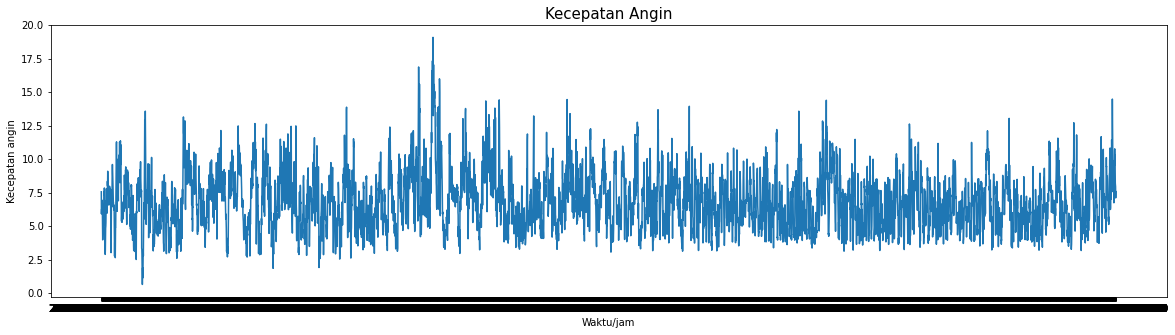

In [34]:
#Buat Plot Time Series
waktu=data['Time'].values
angin=data['WindSpeed'].values

plt.figure(figsize=(20,5))
plt.plot(waktu, angin)
plt.title('Kecepatan Angin',
          fontsize=15)
plt.xlabel('Waktu/jam')
plt.ylabel('Kecepatan angin');

In [35]:
from sklearn.model_selection import train_test_split
data_latih, data_uji=train_test_split(data, test_size=0.2, shuffle=False)

In [36]:
data_latih

,Time,WindSpeed,Power
0,2014-10-07 02:00:00,7.567500,29.605953
1,2014-10-07 03:00:00,5.921667,12.383663
2,2014-10-07 04:00:00,6.256667,14.702530
3,2014-10-07 05:00:00,6.238333,15.391273
4,2014-10-07 06:00:00,6.951667,23.176807
...,...,...,...
5807,2015-07-30 02:00:00,8.096667,39.458956
5808,2015-07-30 03:00:00,5.978333,14.125808
5809,2015-07-30 04:00:00,4.750000,4.453625
5810,2015-07-30 05:00:00,5.446667,12.006700


In [37]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [38]:
train_set = windowed_dataset(data_latih['WindSpeed'], window_size=60, batch_size=100, shuffle_buffer=1000)
test_set= windowed_dataset(data_uji['WindSpeed'], window_size=60, batch_size=100, shuffle_buffer=1000)

In [63]:
#Membuat model
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [54]:
#Batas Toleransi nilai mae
threshold_mae = (data['WindSpeed'].max() - data['WindSpeed'].min()) * 10/100 ;
threshold_mae

1.842833333333337

In [64]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<1.8
       and
       logs.get('val_mae')<1.8):
      print("\nMAE sudah Cukup!")
      self.model.stop_training = True
callbacks = myCallback()

In [65]:
#Menguji model
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100, validation_data=test_set, verbose=2, callbacks=[callbacks])

Epoch 1/100
58/58 - 5s - loss: 6.0328 - mae: 6.5328 - val_loss: 5.1393 - val_mae: 5.6393 - 5s/epoch - 88ms/step
Epoch 2/100
58/58 - 1s - loss: 5.0760 - mae: 5.5758 - val_loss: 4.2219 - val_mae: 4.7219 - 1s/epoch - 24ms/step
Epoch 3/100
58/58 - 1s - loss: 4.0441 - mae: 4.5430 - val_loss: 3.0214 - val_mae: 3.5188 - 1s/epoch - 22ms/step
Epoch 4/100
58/58 - 1s - loss: 2.7018 - mae: 3.1701 - val_loss: 1.5902 - val_mae: 2.0303 - 1s/epoch - 24ms/step
Epoch 5/100
58/58 - 1s - loss: 1.5891 - mae: 2.0324 - val_loss: 0.9870 - val_mae: 1.4099 - 1s/epoch - 23ms/step
Epoch 6/100

MAE sudah Cukup!
58/58 - 1s - loss: 1.2578 - mae: 1.6986 - val_loss: 0.9625 - val_mae: 1.3969 - 1s/epoch - 22ms/step


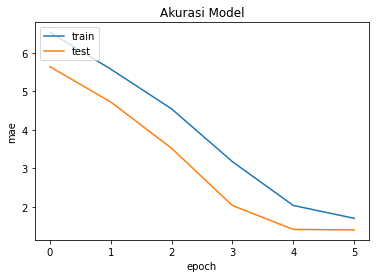

In [66]:
#plot akurasi
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

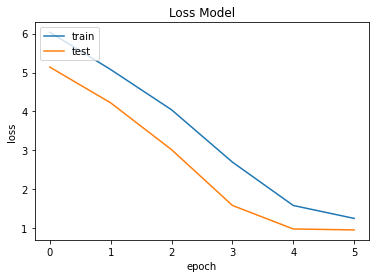

In [69]:
#Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()